## MY EXPLORATION OF THE TITANIC DATASET.
https://www.yourweather.co.uk/news/trending/titanic-10-curiosities-about-most-famous-shipwreck-in-history-oceans.html

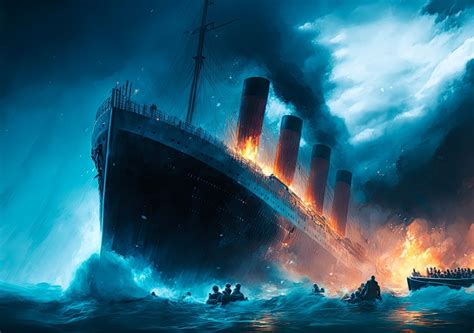



In [ ]:
import kagglehub
kagglehub.login()


In [ ]:
rachaelkibicho_titanic_22_06_path = kagglehub.dataset_download('rachaelkibicho/titanic-22-06')

print('Data source import complete.')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

sns.set_theme(style='darkgrid', context='notebook')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/kaggle/input/titanic-22-06/train.csv')
test = pd.read_csv('/kaggle/input/titanic-22-06/test.csv')
gender_submission = pd.read_csv('/kaggle/input/titanic-22-06/gender_submission.csv')

### Getting the lay of the land


In [ ]:
train.info()

In [ ]:
train['Survived'] = train['Survived'].astype('category')
train['Pclass'] = train['Pclass'].astype('category')
train['Sex'] = train['Sex'].astype('category')
train['Cabin'] = train['Cabin'].astype('category')
train['Embarked'] = train['Embarked'].astype('category')

In [ ]:
train.info()

In [ ]:
train.describe().T

In [ ]:
train.head()

In [ ]:
train.columns

In [ ]:
train.nunique()

### Checking for inconsistencies

#### Let's drop the unnecessary values

In [ ]:
train = train.drop(columns = ['PassengerId'])
train = train.drop(columns = ['Name'])

In [ ]:
def show_unique_values(train):
    categorical_columns = train.select_dtypes(include='category').columns
    print(f'Categorical Columns: {list(categorical_columns)}\n')

    for col in categorical_columns:
        print(f'Unique valus in {col} are : {train[col].unique()}\n')

#### Let's now check the unique categorical values in the dataset

In [ ]:
show_unique_values(train)

In [ ]:
duplicates = train[train.duplicated()]
duplicates

In [ ]:
#Let's keep the first of each duplicate
train.drop_duplicates(keep='first')

#### Let's check the handle these missing values.

In [ ]:
#Let's visualize the missing data
msno.bar(train)

In [ ]:
#Null percentages
missing_values = train.isnull().sum().sort_values(ascending=False)

missing_percentages = (missing_values/len(train)) * 100

print(pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentages
}))

In [ ]:
#Cabin column has got to go

train = train.drop(columns = ['Cabin'])
train.columns

In [ ]:
#Imputing mean on age null values
train.Age.fillna(train['Age'].mean(), inplace=True)

In [ ]:
#Imputing mode on Pclass since it is categorical
train.Embarked.fillna(train['Embarked'].mode()[0], inplace=True)

In [ ]:
msno.bar(train)

### Univariate analysis for numerical columns


#### What is the age distribution of passengers

In [ ]:
plt.figure(figsize=(25,10))
sns.histplot(data=train, x='Age', bins=100, kde=True)
plt.title('A graph to show the age distribution of passengers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [ ]:
print(f"This is the age mean: {train['Age'].mean()}")
print(f"This is the age median: {train['Age'].median()}")
print(f"This is the age skew: {train['Age'].skew()}")

The median is greater than the mean, so the distribution is negatively skewed.


#### How many passengers embarked from each location

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(data=train, x='Embarked')
plt.show()

In [ ]:
train.groupby('Embarked').count()

Looks like most people came from point S.

#### Are ticket prices evenly distributed or are they skewed?

In [ ]:
plt.figure(figsize=(25,10))
sns.kdeplot(data=train, x='Fare', shade=True)
plt.title('A graph to show the ticket price distribution ')
plt.xlabel('Ticket')
plt.ylabel('Count')
plt.show()

In [ ]:
print(f"This is the ticket price mean: {train['Fare'].mean()}")
print(f"This is the ticket price median: {train['Fare'].median()}")
print(f"This is the ticket price skew: {train['Fare'].skew()}")

The median is less than the mean, so the distribution is positively skewed.

### Bivariate analysis for numerical columns


#### Does the fare change depending on the Pclass?

In [ ]:
# Visualizing distributions of fare grouped by Pclass
plt.figure(figsize=(10,8))
sns.boxplot(x='Pclass', y='Fare', data=train)
plt.title('Boxplot for Pclass versus Fare')
plt.xlabel('Passenger class')
plt.show()

Yes indeed fare increases with Pclass, although there are exceptions..

#### Are younger passengers more likely to survive in the Titanic?


In [ ]:
# Let's use a count plot perhaps.
plt.figure(figsize=(10,8))
sns.histplot(data=train, x='Age', hue='Survived', color='dark')
plt.title('Count Plot for showing passengers age against survival')
plt.xlabel('Age of Passenger')
plt.show()

Yes indeed. It is only between age 0 to age 15, that we see there are more survivors than those who perished.

#### Does the Embarked location affect survival rate?

In [ ]:
survival_by_embarked = train[train['Survived']==1].groupby('Embarked').count()['Survived']
death_by_embarked = train[train['Survived']==0].groupby('Embarked').count()['Survived']

print(survival_by_embarked)
print(death_by_embarked)




Given that the order of the populations that embarked was S greatest, then C then Q, it is not surprising that the toll of deaths and survivals follow the same route.

### Multivariate analysis

#### How do Pclass, Age, and Fare jointly affect survival

Using multivariate regression technique

In [ ]:
import statsmodels.api as sm
X = train[['Pclass', 'Age', 'Fare']].copy()

#adding intercept
X = sm.add_constant(X)

y = train['Survived']
model = sm.Logit(y, X).fit()
print(model.summary())


The very low p values of Pclass and Age show that they affect greatly the rates of survival, unlike Fare.

In [ ]:
plt.figure(figsize=(8,5))
sns.violinplot(x='Embarked', y = 'Survived', data=train)
plt.title('Survival Rate by Embarked points')
plt.xlabel('Survived(0=no, 1=yes')
plt.show()

#### Are survival rates different for Embarked locations when considering Pclass?

In [ ]:
sns.catplot(data=train, x='Embarked', hue='Survived', col='Pclass', kind='count', height=4, aspect=0.8)
plt.subplots_adjust(top=0.8)
plt.suptitle('Survival Counts by Embarkation Port and Passenger Class')
plt.show()

It seems like those who embarked on 1st class especially from Cherbourg were more likly to survive than those who embarked from Southampton on 3rd class.  

### OUTLIERS


#### DETECTING OUTLIERS

#### Now let's handle them

In [ ]:
#using zscores
from scipy.stats import zscore

def detect_outliers_zscore(data, threshold=3):
    zscores = zscore(data.dropna())
    outliers = data[(abs(zscores) > threshold) | (abs(zscores < -threshold))]
    return outliers


outliers_parch = detect_outliers_zscore(train['Parch'])
outliers_age = detect_outliers_zscore(train['Age'])
outliers_fare = detect_outliers_zscore(train['Fare'])

print(f"Number of extreme values in parch: {len(outliers_parch)}, in age {len(outliers_age)}, in fare {len(outliers_fare)}")


I'll keep the outliers to study wealth in passengers and their ages.

#### Target variable exploration

Distribution of target variable

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Pclass', hue='Sex', data = train[train['Survived'] == 1], palette='Set1')
plt.title('Survivors by Gender and Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survivor count')
plt.legend()
plt.show()


Men who came on first class are likely to survive than men who came on third class. Generally, women are more likely to survive than men, with the exception of first class, which I think is a wealth issue.

In [ ]:
sns.catplot(data=train, x='Embarked', hue='Survived', col='Pclass', kind='count', height=4, aspect=0.8)
plt.subplots_adjust(top=0.8)
plt.suptitle('Survival Counts by Embarkation Port and Passenger Class')
plt.show()

It seems like those who embarked on 1st class especially from Cherbourg were more likly to survive than those who embarked from Southampton on 3rd class.  

Skewness of the Survival feature

In [ ]:
plt.figure(figsize=(25,10))
sns.countplot(x='Survived',data=train, palette='Set1')
plt.title('A graph to show the survival distribution ')
plt.xlabel('Survival')
plt.ylabel('Count')
plt.show()